In [50]:
import scipy.stats as sps
import numpy as np

import pandas as pd
import math
import random
import sklearn

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

from libmf import mf

In [51]:

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1')

r_cols = ['user_id', 'item_id', 'rating']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, usecols=range(3),
                      encoding='latin-1')

m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')


In [52]:
ratings_train, ratings_test = train_test_split(ratings, test_size=0.1, shuffle=True)

In [53]:
ratings_train

,user_id,item_id,rating
56292,200,234,4
14354,76,23,5
71079,385,176,2
99572,894,166,4
61009,392,463,3
...,...,...,...
52786,288,1065,4
98051,913,289,5
14220,286,161,2
74771,835,484,4


In [54]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    if person_id in interactions_df.index:
        interacted_items = interactions_df.loc[person_id]['item_id']
    else:
        return set()
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [55]:
from CF_Predictor import CFRecommender

cf_recommender_model = CFRecommender(ratings_train)


In [56]:
def change_distribution(model_class, ratings_train, ratings_test, probability=0.9):
    model = model_class(ratings_train)
    ratings_test_indexed = ratings_test.set_index("user_id")
    changed_ratings = pd.DataFrame(columns=ratings_test.columns).set_index("user_id")
    for person_id in ratings_test["user_id"].unique():
        interacted_items_rows = ratings_test_indexed.loc[[person_id]].set_index("item_id")
        
        currently_interacted_items_set = get_items_interacted(person_id,
                                                                   ratings_train.set_index("user_id"))
        for item_id, row in interacted_items_rows.iterrows():
            new_item_id = item_id
            new_rate = row['rating']
            if np.random.random() <= float(probability):
                recommended_item = model.recommend_items(person_id,
                          items_to_ignore=currently_interacted_items_set,
                          topn=1)
                new_item_id = recommended_item["item_id"].iloc[0]
                new_rate = recommended_item["rating"].iloc[0]
            currently_interacted_items_set.add(new_item_id)
            changed_ratings.loc[person_id] = [new_item_id, new_rate]
    changed_ratings["item_id"] = changed_ratings["item_id"].astype('int')
    return changed_ratings.reset_index()


In [44]:
change_distribution(CFRecommender, ratings_train, ratings_test)

/tmp/ipykernel_96478/1917878580.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4884046302977379' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  changed_ratings.loc[person_id] = [new_item_id, new_rate]


,user_id,item_id,rating
0,70,732,0.414694
1,324,321,0.426894
2,664,169,0.457740
3,864,62,0.473864
4,556,483,0.470573
...,...,...,...
917,129,301,0.406519
918,300,748,0.383757
919,810,258,0.481807
920,247,313,0.404094


In [57]:
class Distribution:
    def __init__(self, rating):
        self.fit_rating(rating)

    def fit_rating(self, rating):
        grouped_users = rating.groupby('user_id')['rating'].mean().reset_index()
        probabilities_users = grouped_users['rating'] / grouped_users['rating'].sum()
        self.users = pd.DataFrame({'user_id': grouped_users['user_id'], 'probability': probabilities_users})
        grouped_items = rating.groupby('item_id')['rating'].mean().reset_index()
        probabilities_items = grouped_items['rating'] / grouped_items['rating'].sum()
        self.items = pd.DataFrame({'item_id': grouped_items['item_id'], 'probability': probabilities_items})

    def sample_users(self, size):
        return np.random.choice(self.users['user_id'], size=size, p=self.users['probability'])

    def sample_items(self, size):
        return np.random.choice(self.items['item_id'], size=size, p=self.items['probability'])

    def plot_feature_distribution(self, ax, feature, feature_name, mode='user_id'):
        if mode=='user_id':
          distribution = self.users
        elif mode=='item_id':
          distribution = self.items
        else:
          return
        merged_df = pd.merge(distribution, feature, on=mode, how='inner')
        ax.bar(merged_df[feature_name], merged_df['probability'])

    # def plot_feature_distribution(self, sample, ax, feature, feature_name, mode='user_id'):
    #     merged_df = pd.merge(sample, feature, on=mode, how='inner')
    #     ax.hist(merged_df[feature_name], bins=30, density=True)

In [60]:
num_of_steps = 10
new_ratings = ratings

  0%|          | 0/10 [00:00<?, ?it/s]

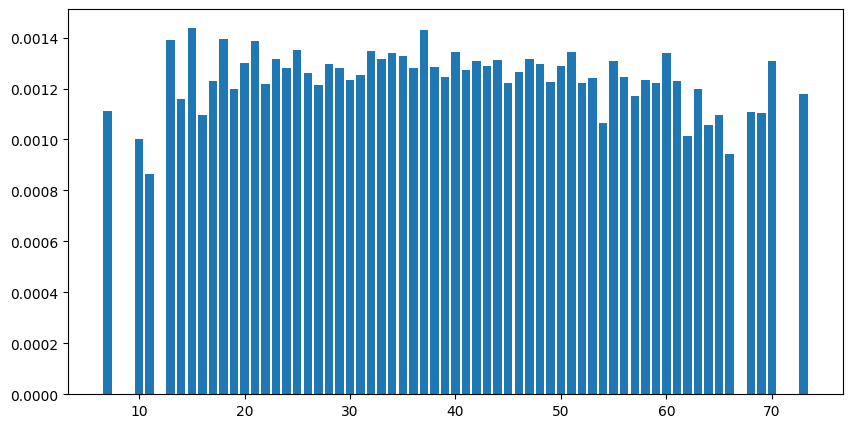

 10%|█         | 1/10 [00:31<04:41, 31.32s/it]

       user_id  item_id    rating
0          429        73  3.000000
1          660       201  3.000000
2          313       542  3.000000
3          637      1344  4.000000
4          435       763  5.000000
...        ...       ...       ...
70938      133       268  0.382211
70939       98       238  0.359465
70940      874        13  0.408509
70941       39       328  0.408919
70942      571       257  0.353988

[70943 rows x 3 columns]


 20%|██        | 2/10 [00:53<03:26, 25.80s/it]

       user_id  item_id    rating
0           13       518  4.000000
1          561       762  3.000000
2          295       222  4.000000
3          848       496  2.000000
4          234       357  4.000000
...        ...       ...       ...
50596      824       258  0.395461
50597      820       300  0.416578
50598      571        32  2.000000
50599      762       153  0.389581
50600      644       300  0.546439

[50601 rows x 3 columns]


 30%|███       | 3/10 [01:08<02:28, 21.15s/it]

       user_id  item_id    rating
0          587       310  3.000000
1          795        89  4.000000
2           63       508  0.426880
3          868       211  3.000000
4          346        68  3.000000
...        ...       ...       ...
36357      631       877  2.000000
36358       47       302  0.399186
36359      564       302  0.393345
36360      107       328  0.380216
36361      762       286  0.406346

[36362 rows x 3 columns]


 40%|████      | 4/10 [01:22<01:48, 18.05s/it]

       user_id  item_id    rating
0          215       179  4.000000
1          171       315  4.000000
2          853       748  2.000000
3          347       298  5.000000
4          221       240  4.000000
...        ...       ...       ...
26382      691       427  0.337709
26383       19        64  0.323799
26384      657       258  0.365988
26385      849       257  0.303065
26386      857       269  0.336281

[26387 rows x 3 columns]


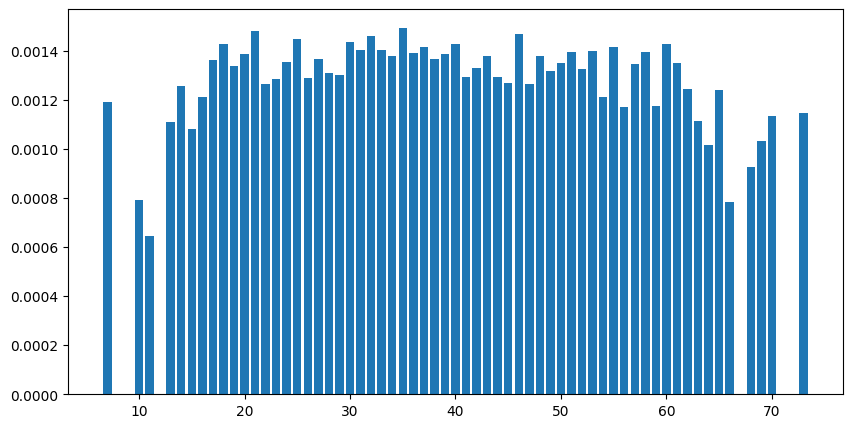

 50%|█████     | 5/10 [01:33<01:18, 15.61s/it]

       user_id  item_id    rating
0          606       138  3.000000
1          889      1014  2.000000
2          187       660  5.000000
3          938      1254  1.000000
4          344       301  4.000000
...        ...       ...       ...
19380      888       423  0.354940
19381      350       210  0.398620
19382      384       328  0.324156
19383      801       258  0.392514
19384      662        14  0.366177

[19385 rows x 3 columns]


 60%|██████    | 6/10 [01:39<00:50, 12.51s/it]

       user_id  item_id    rating
0          293       924  2.000000
1          471       172  0.304168
2           97       168  4.000000
3          308        24  4.000000
4          747       215  5.000000
...        ...       ...       ...
14466      760       300  0.289000
14467      202         1  0.261836
14468      759       333  0.347133
14469        4       300  0.314244
14470      547       300  0.283640

[14471 rows x 3 columns]


 70%|███████   | 7/10 [01:44<00:30, 10.01s/it]

       user_id  item_id    rating
0          386       118  3.000000
1           99       123  3.000000
2          943       508  0.396836
3          279       165  4.000000
4          291       214  4.000000
...        ...       ...       ...
10988      388       302  0.248679
10989       19       496  0.222773
10990      260         1  0.231471
10991      367       288  5.000000
10992      574       286  0.267852

[10993 rows x 3 columns]


 80%|████████  | 8/10 [01:48<00:16,  8.11s/it]

      user_id  item_id    rating
0         496       402  0.366618
1         637       300  0.231212
2          18       435  4.000000
3         269       137  4.000000
4         629       886  3.000000
...       ...       ...       ...
8543      728       511  0.012802
8544      611       269  0.010899
8545      206       286  0.013162
8546      530       318  0.012755
8547      300       496  0.011675

[8548 rows x 3 columns]


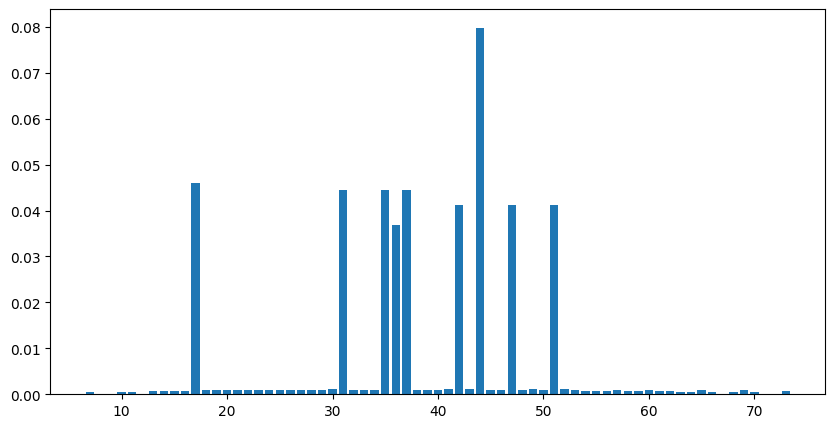

 90%|█████████ | 9/10 [01:53<00:06,  6.94s/it]

      user_id  item_id    rating
0         543      1159  5.000000
1          42        95  0.366289
2         363       588  2.000000
3         302       286  0.263612
4         747       659  4.000000
...       ...       ...       ...
6793      623       181  0.006225
6794      546        56  0.006456
6795      761       222  0.006618
6796      372         4  0.006632
6797      550       682  4.000000

[6798 rows x 3 columns]


100%|██████████| 10/10 [01:56<00:00, 11.63s/it]

      user_id  item_id       rating
0         738       188     3.000000
1         832       258     0.010834
2         689       275     0.006183
3          71       222     0.354934
4         292       200     0.287247
...       ...       ...          ...
5540      941       257     0.002247
5541      377       313     0.002575
5542       84       357     0.002895
5543      768       357     0.003165
5544      143       302  1713.071239

[5545 rows x 3 columns]


In [61]:
for i in tqdm(range(1, num_of_steps + 1)):
    current_distr = Distribution(new_ratings)
    if i in np.arange(1, num_of_steps, 4):
        plt.figure(figsize=(10, 5))
        current_distr.plot_feature_distribution(ax = plt.gca(), feature=users[["user_id", "age"]], feature_name="age")
        plt.show()
    new_ratings_train, new_ratings_test = train_test_split(new_ratings, test_size=0.3, shuffle=True)
    new_ratings_test = change_distribution(CFRecommender, new_ratings_train, new_ratings_test)
    new_ratings = pd.concat([new_ratings_train, new_ratings_test], ignore_index=True)
    print(len(new_ratings))